Train/Val split: (189, 13), (189,) / (81, 13), (81,)
Num samples - Train: 189, Val: 81
=== Training with LR=0.0005, Hidden Size=64 ===


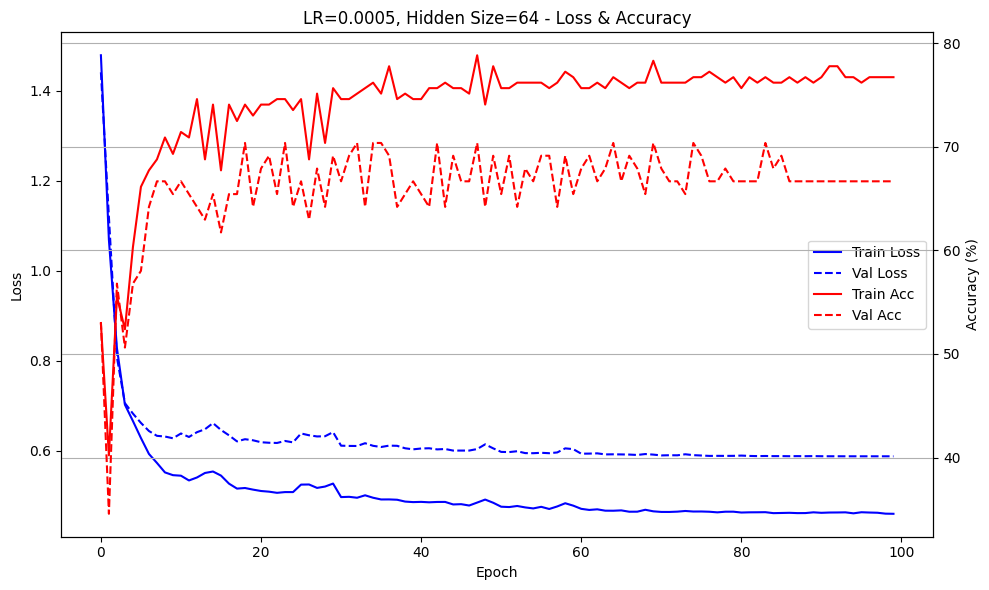

=== Training with LR=0.0005, Hidden Size=128 ===


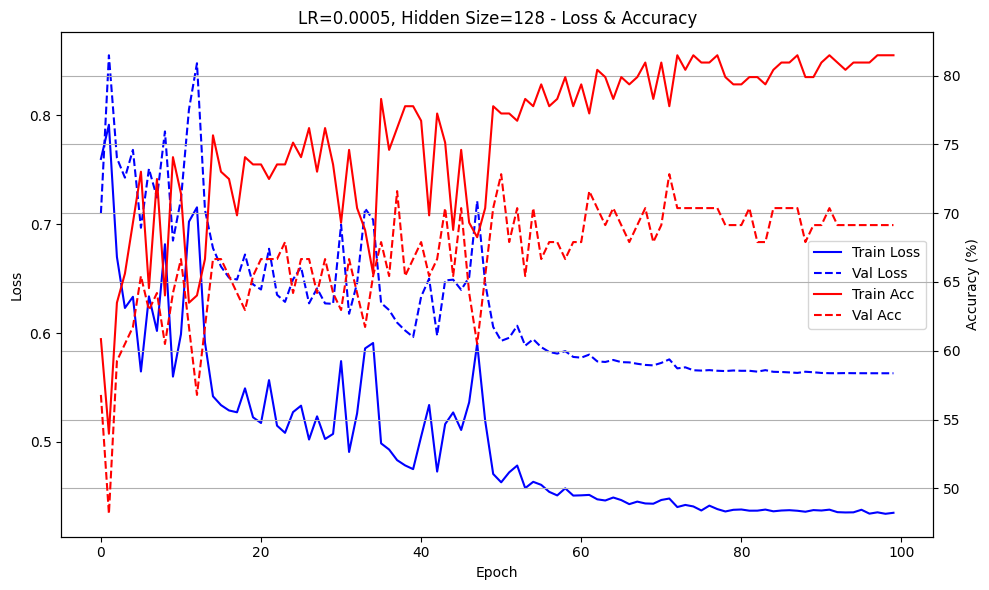

=== Training with LR=0.0005, Hidden Size=256 ===


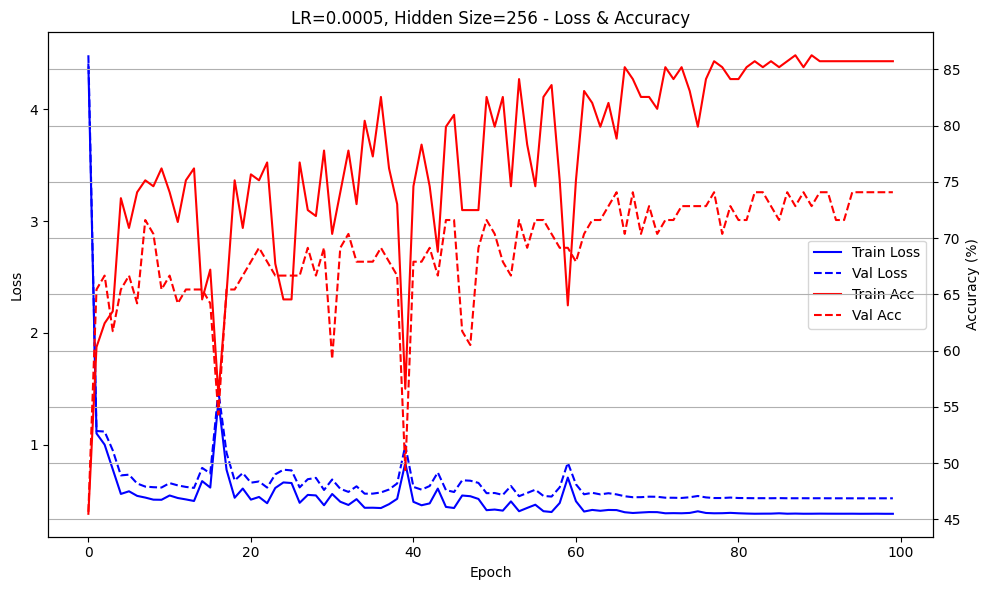

=== Training with LR=0.001, Hidden Size=64 ===


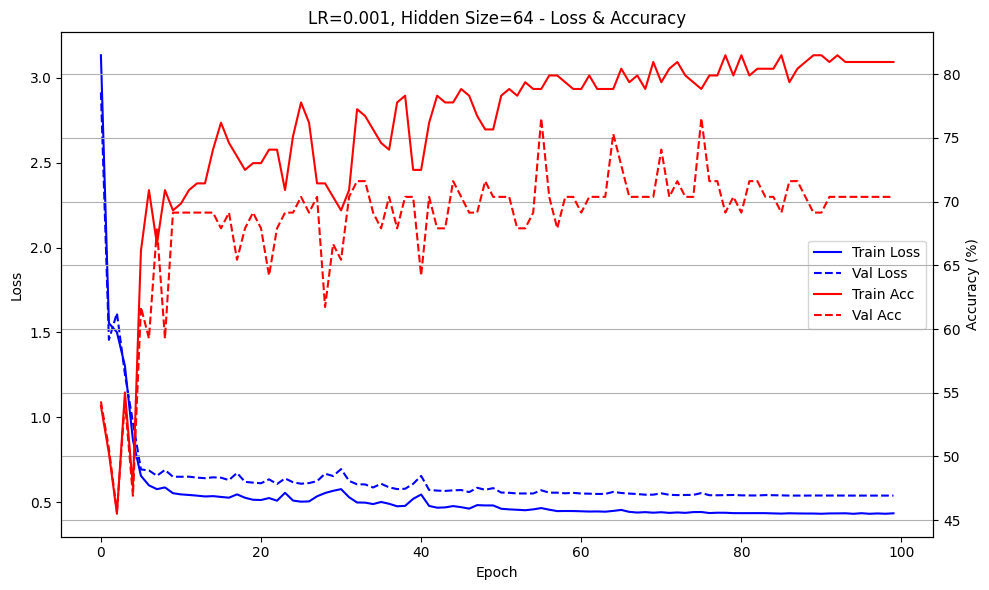

=== Training with LR=0.001, Hidden Size=128 ===


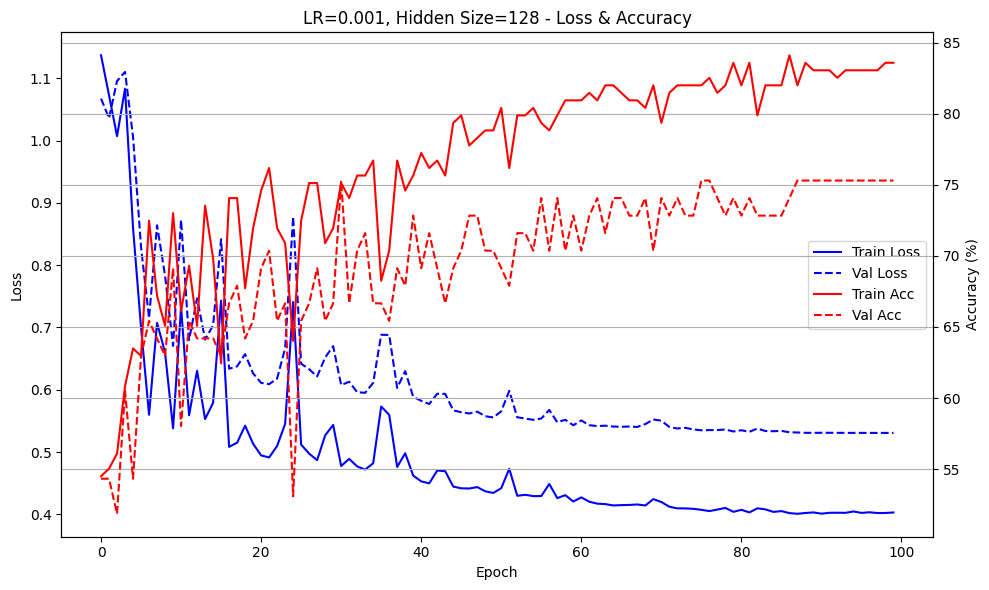

=== Training with LR=0.001, Hidden Size=256 ===


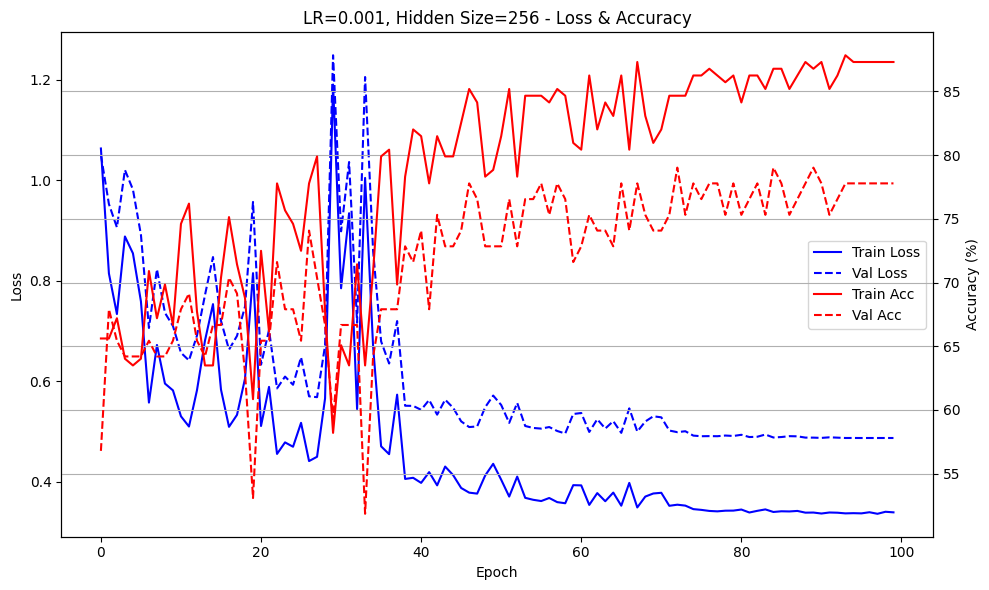

=== Training with LR=0.01, Hidden Size=64 ===


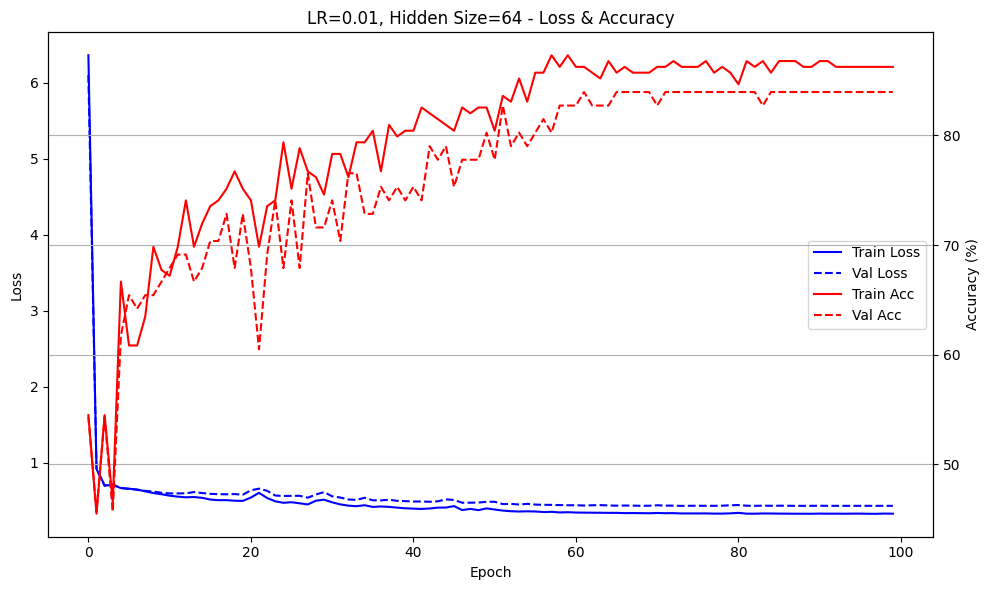

=== Training with LR=0.01, Hidden Size=128 ===


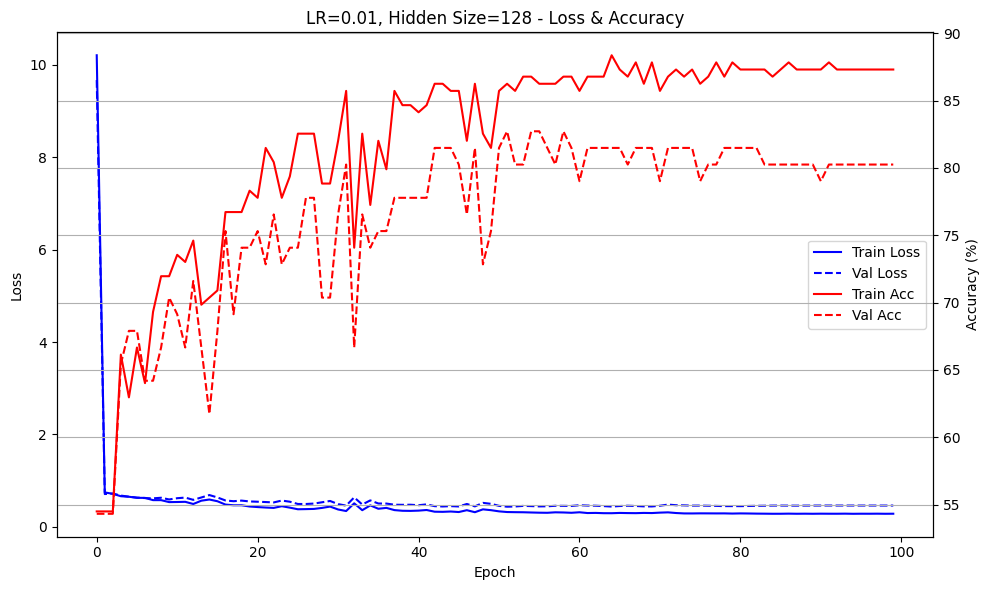

=== Training with LR=0.01, Hidden Size=256 ===


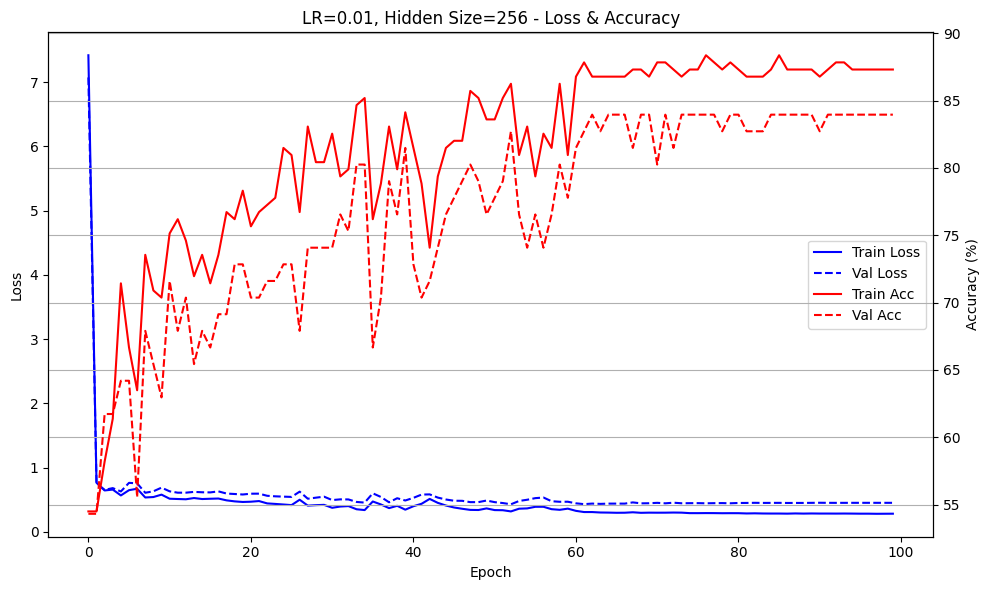


========== Hyperparameter Search Results ==========


,Learning Rate,Hidden Size,Train Loss,Train Acc,Val Loss,Val Acc,Test Loss,Test Acc
0,0.0005,64,0.517461,74.07%,0.625727,70.37%,0.657366,64.52%
1,0.0005,128,0.463111,77.25%,0.592808,72.84%,0.623550,64.52%
2,0.0005,256,0.414881,78.84%,0.554456,74.07%,0.561543,64.52%
3,0.0010,64,0.463446,78.84%,0.570237,76.54%,0.619062,64.52%
4,0.0010,128,0.479755,75.13%,0.607563,75.31%,0.625029,64.52%
5,0.0010,256,0.354795,84.66%,0.498975,79.01%,0.502734,70.97%
6,0.0100,64,0.345845,86.24%,0.436780,83.95%,0.440815,74.19%
7,0.0100,128,0.323113,86.24%,0.437554,82.72%,0.416461,77.42%
8,0.0100,256,0.306832,86.77%,0.440271,83.95%,0.428259,77.42%


In [ ]:
#############################################
# 1. 資料讀取與前處理
#############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 請自行修改成你的檔案路徑
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/DL_1132/heart_dataset_train_all.csv'
TEST_PATH  = '/content/drive/MyDrive/Colab Notebooks/DL_1132/heart_dataset_test.csv'

# 讀取訓練資料
df_train = pd.read_csv(TRAIN_PATH)
df_train.dropna(inplace=True)  # 若有空值直接丟棄，也可自行決定策略

# 若資料集中性別、胸痛等欄位仍是字串，要先轉數值 (示範)
sex_map = {'Male': 0, 'Female': 1}
if 'sex' in df_train.columns:
    df_train['sex'] = df_train['sex'].map(sex_map)

cp_map = {'low': 0, 'medium': 1, 'high': 2, 'severe': 3}
if 'cp' in df_train.columns:
    df_train['cp'] = df_train['cp'].map(cp_map)

# 轉成 NumPy (假設前 13 欄為特徵、第 14 欄為標籤)
np_data = df_train.values
# 打亂並切分 train/val
np.random.shuffle(np_data)
split_point = int(len(np_data) * 0.7)

x_train = np_data[:split_point, :13]
y_train = np_data[:split_point, 13]
x_val   = np_data[split_point:, :13]
y_val   = np_data[split_point:, 13]

print(f"Train/Val split: {x_train.shape}, {y_train.shape} / {x_val.shape}, {y_val.shape}")

#############################################
# 2. 建立 DataLoader (Train, Val)
#############################################
import torch
from torch.utils.data import TensorDataset, DataLoader

# 轉成 PyTorch Tensor
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
x_val_tensor   = torch.from_numpy(x_val).float()
y_val_tensor   = torch.from_numpy(y_val).long()

# 建立 Dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(x_val_tensor,   y_val_tensor)

# 建立 DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Num samples - Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}")


#############################################
# 3. 定義 Model（可調 Hidden Layer）
#############################################
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(13, hidden_size),  # 13特徵 → hidden_size
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)    # 二元分類
        ).cuda()

    def forward(self, x):
        return self.network(x)

#############################################
# 4. 定義評估函式(evaluate)
#############################################
def evaluate(model, loader, criterion):
    """用來計算 model 在指定 DataLoader 上的平均 loss 和 accuracy。"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.cuda(), labels.cuda()

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100.0 * correct / total_samples
    return avg_loss, accuracy

#############################################
# 5. 定義 訓練 & 驗證 流程 (train_and_evaluate)
#############################################
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_and_evaluate(lr, hidden_size, epochs):
    """
    - lr: 學習率 (float)
    - hidden_size: 隱藏層大小 (int)
    - epochs: 訓練回合數 (int)
    回傳: (final_train_loss, final_train_acc, final_val_loss, final_val_acc, final_test_loss, final_test_acc)
    """
    # 建立模型
    model = Model(hidden_size=hidden_size).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    best_val_loss = float('inf')
    best_val_acc  = -1

    # 儲存每一 epoch 的 loss / acc（for 繪圖用）
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # 訓練主迴圈
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 每個 epoch 結束更新學習率
        lr_scheduler.step()

        # 估計 Train/Val 效果 (可視需要印出來)
        train_loss, train_acc = evaluate(model, train_loader, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # 存進歷史紀錄，之後用來畫圖
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # 若要以 Val 作為選擇最佳模型的依據：
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # 暫存最佳權重
            torch.save(model.state_dict(), 'best_temp_model.pth')

    # 訓練完之後，載入最佳權重
    model.load_state_dict(torch.load('best_temp_model.pth'))

    # 計算最終 Train / Val / Test 的 loss & acc
    final_train_loss, final_train_acc = evaluate(model, train_loader, criterion)
    final_val_loss,   final_val_acc   = evaluate(model, val_loader,   criterion)

    # 讀取/建立 Test DataLoader
    final_test_loss, final_test_acc = evaluate(model, test_loader, criterion)

    return (final_train_loss, final_train_acc,
            final_val_loss, final_val_acc,
            final_test_loss, final_test_acc),history

#############################################
# 6. 建立 Test DataLoader 並做批次調參
#############################################
# 讀取測試資料 (假設同樣前 13 欄是特徵、第14欄是標籤)
df_test = pd.read_csv(TEST_PATH)
df_test.dropna(inplace=True)

test_data = df_test.values
x_test = torch.from_numpy(test_data[:, :13]).float()
y_test = torch.from_numpy(test_data[:, 13]).long()

test_dataset = TensorDataset(x_test, y_test)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定義要嘗試的超參數
learning_rates = [0.0005, 0.001, 0.01]
hidden_sizes   = [64, 128, 256]
ep = 100 # Epochs=100

results = []

for lr in learning_rates:
    for hs in hidden_sizes:
        print(f"=== Training with LR={lr}, Hidden Size={hs} ===")
        (train_loss, train_acc,
         val_loss, val_acc,
         test_loss, test_acc),history = train_and_evaluate(lr=lr, hidden_size=hs, epochs=ep)

        results.append({
            'Learning Rate': lr,
            'Hidden Size': hs,
            'Train Loss': train_loss,
            'Train Acc': f"{train_acc:.2f}%",
            'Val Loss': val_loss,
            'Val Acc': f"{val_acc:.2f}%",
            'Test Loss': test_loss,
            'Test Acc': f"{test_acc:.2f}%"
        })

        ## (hw-2) 畫圖分析
        fig, ax1 = plt.subplots(figsize=(10,6))
        # 左側 y 軸顯示 Loss
        ax1.plot(history['train_loss'], linestyle='-', color='blue', label='Train Loss')
        ax1.plot(history['val_loss'], linestyle='--', color='blue', label='Val Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')

        # 建立右側 y 軸
        ax2 = ax1.twinx()
        ax2.plot(history['train_acc'], linestyle='-', color='red', label='Train Acc')
        ax2.plot(history['val_acc'], linestyle='--', color='red', label='Val Acc')
        ax2.set_ylabel('Accuracy (%)')

        # 合併圖例
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

        plt.title(f'LR={lr}, Hidden Size={hs} - Loss & Accuracy')
        plt.grid(True)
        plt.tight_layout()
        plt.show()



## (hw-1) 轉為 DataFrame 方便瀏覽
df_results = pd.DataFrame(results)
print("\n========== Hyperparameter Search Results ==========")
df_results
